In [123]:
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.mask import mask, raster_geometry_mask
from rasterio.enums import Resampling
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from skimage.measure import block_reduce

In [2]:
fp = r'../data/population/count/1990/GHS_POP_E1990_GLOBE_R2023A_4326_30ss_V1_0_R10_C21/GHS_POP_E1990_GLOBE_R2023A_4326_30ss_V1_0_R10_C21.tif'
rasterio_img = rasterio.open(fp)

In [3]:
# tmp = rasterio.open('../data/tmp.tif')

In [5]:
# data = tmp.read(1)
# show(data[1070:1200, 1070:1200], cmap='terrain')

In [6]:
rasterio_img.height, rasterio_img.width, rasterio_img.crs, rasterio_img.bounds

(1200,
 1200,
 CRS.from_epsg(4326),
 BoundingBox(left=19.992083276545827, bottom=-10.90041641989488, right=29.992083236938136, top=-0.900416460140832))

In [7]:
# data = rasterio_img.read([1])
# img.xy(0,2)
# show(data[:, 0:1000, 0:1000])

### Combining country geometeries and creating a bounding box

In [2]:
all_country_shapefile = gpd.read_file("../data/country_geometry/all_country/ne_10m_admin_0_countries.shp")

# # extract the geometry in GeoJSON format
all_country_geometry = all_country_shapefile.geometry.values # list of shapely geometries
country_names = list(all_country_shapefile.SOV_A3)
country_geometry_dict = {country_names[i]: all_country_geometry[i] for i in range(len(all_country_geometry))}

In [3]:
country_codes = ["BDI", "KEN", "RWA", "UGA", "TZA"]

union_geom = None
for country_code in country_codes:
    country_geometry = country_geometry_dict[country_code]
    
    ## This is to remove small islands away from the mainland
    if isinstance(country_geometry, MultiPolygon):
        num_geoms = len(country_geometry_dict[country_code].geoms)
        geoms_area = [country_geometry.geoms[i].area for i in range(num_geoms)]
        country_geometry = country_geometry.geoms[geoms_area.index(max(geoms_area))]
    
    if union_geom is None:
        union_geom = country_geometry
    else:
        union_geom = union_geom.union(country_geometry)

In [4]:
# union_geom.geometry.map(lambda z: z.exterior.xy)

In [5]:
# country_geometry_dict["KEN"].bounds
# union_geom.geoms[0]
# union_geom.geoms[0].geometry.map(lambda z: z.exterior.xy)

In [6]:
left, bottom, right, top = union_geom.bounds
lon_point_list = [left, left, right, right]
lat_point_list = [bottom, top, top, bottom]

bounding_geom = Polygon(zip(lon_point_list, lat_point_list))

In [7]:
polygon = gpd.GeoDataFrame(index=[0, 1], crs='epsg:4326', geometry=[bounding_geom.boundary, union_geom])

<AxesSubplot:>

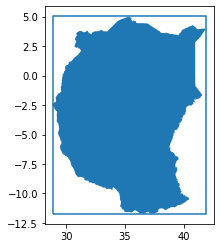

In [8]:
polygon.plot()

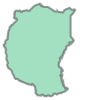

In [9]:
union_geom

In [10]:
bounding_geom.bounds

(28.857235555000074, -11.73127248199998, 41.885019165000074, 5.030375822607695)

In [11]:
type(union_geom)

shapely.geometry.polygon.Polygon

### Filtering out the population density of the combined geometry from the population density geotiff

In [17]:
polygon_mapping = mapping(union_geom)
out_image, _ = mask(rasterio_img, [polygon_mapping], crop=True)

In [18]:
# np.argmax(out_image[:,:1000, 500:800], axis=1)

In [19]:
# plt.imshow(out_image[0][1500:2500, 1000:2000], cmap="pink")

In [20]:
# np.argmax(out_image[0][:1000, 500:800]*2)

### Filtering out the NTL values of the combined geometry from the NTL geotiff  

In [21]:
## Next step: use union_geom to extract NTL values

In [12]:
fp = r'../data/earth_observation_group/annual/1994/F101994.v4b.global.intercal.stable_lights.avg_vis.tif'
ntl_img = rasterio.open(fp)

In [13]:
ntl_img.height, ntl_img.width, ntl_img.crs, ntl_img.bounds

(16801,
 43201,
 CRS.from_epsg(4326),
 BoundingBox(left=-180.00416666665, bottom=-65.00416610665, right=180.00416522665, top=75.00416666665))

In [14]:
polygon_mapping = mapping(union_geom)
ntl_out_image, _ = mask(ntl_img, [polygon_mapping], crop=True)

In [15]:
ntl_out_image.shape

(1, 2013, 1564)

In [16]:
# out_image.shape

NameError: name 'out_image' is not defined

In [27]:
917.67+917.67+917.67+836.22+510.25

4099.48

In [214]:
fp = r'../data/population/count/1995/population_count.tif'
pop_tif = rasterio.open(fp)

In [215]:
pop_tif.bounds, pop_tif.crs

(BoundingBox(left=19.992083276544747, bottom=-20.900416379650295, right=49.99208315772151, top=9.099583499612223),
 CRS.from_epsg(4326))

In [19]:
def get_bounding_geom_tif(tif_file):
    left, bottom, right, top = tif_file.bounds
    lon_point_list = [left, left, right, right]
    lat_point_list = [bottom, top, top, bottom]

    return Polygon(zip(lon_point_list, lat_point_list))

In [20]:
# left, bottom, right, top = pop_tif.bounds
# lon_point_list = [left, left, right, right]
# lat_point_list = [bottom, top, top, bottom]

# bounding_geom = Polygon(zip(lon_point_list, lat_point_list))
bounding_geom = get_bounding_geom_tif(pop_tif)
selected_bounding_geom = union_geom

In [21]:
bounding_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bounding_geom])
selected_bounding_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[selected_bounding_geom.boundary])

In [22]:
bounding_geom.bounds

(19.992083276544747, -20.900416379650295, 49.99208315772151, 9.099583499612223)

<AxesSubplot:>

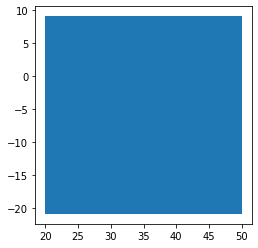

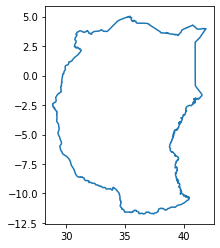

In [23]:
bounding_polygon.plot()
selected_bounding_polygon.plot()

In [24]:
mapping(bounding_geom)

{'type': 'Polygon',
 'coordinates': (((19.992083276544747, -20.900416379650295),
   (19.992083276544747, 9.099583499612223),
   (49.99208315772151, 9.099583499612223),
   (49.99208315772151, -20.900416379650295),
   (19.992083276544747, -20.900416379650295)),)}

In [187]:
polygon_mapping = mapping(bounding_geom)
pop_out_image, _ = mask(pop_tif, [polygon_mapping], crop=False, nodata=-10.0)


In [317]:
mask_polygon_mapping = get_bounding_geom_tif(union_geom)
pop_mask_image, _= mask(pop_tif, [mask_polygon_mapping], crop=False, nodata=-10.0)
pop_mask_image_cropped, _= mask(pop_tif, [mask_polygon_mapping], crop=True, nodata=-10.0)
pop_mask_image = np.squeeze(pop_mask_image)
pop_mask_image_cropped = np.squeeze(pop_mask_image_cropped)
pop_mask_image_cropped = pop_mask_image_cropped[:, 1: -1]

In [319]:
pop_mask_image_cropped.shape

(2012, 1563)

In [320]:
pop_mask_image[np.where(pop_mask_image != -10.0)] = 255
pop_mask_image[np.where(pop_mask_image == -10.0)] = 0

In [321]:
# tmp_image = np.zeros(pop_mask_image.shape)
# tmp_image[np.where(pop_mask_image == False)] = 255
# tmp_image

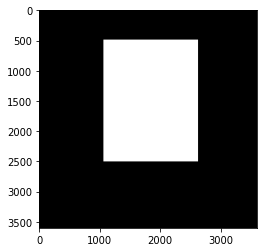

In [322]:
plt.imshow(np.squeeze(pop_mask_image), cmap="gray")

In [323]:
elev = np.extract(pop_out_image != pop_tif.nodata, pop_out_image)
elev = np.reshape(elev, pop_out_image.shape[1:])

In [324]:
elev.shape, pop_out_image.shape

((3600, 3600), (1, 3600, 3600))

In [325]:
fp = r'../data/earth_observation_group/monthly/2015/01/SVDNB_npp_20150101-20150131_global_vcmcfg_v10_c201505111709.avg_rade9h.tif'
ntl_tif = rasterio.open(fp)
ntl_tif.crs, ntl_tif.bounds

(CRS.from_epsg(4326),
 BoundingBox(left=-180.00208333335, bottom=-65.00208445335001, right=180.00208621335, top=75.00208333335))

In [326]:
polygon_mapping = mapping(bounding_geom)
ntl_out_image, _ = mask(ntl_tif, [polygon_mapping], crop=True, all_touched=False)

In [327]:
# show(ntl_out_image, cmap="gray")
ntl_out_image.shape
# ntl_out_image[0, 1000:, 1000:]

(1, 7201, 7201)

In [328]:
ntl_out_image = np.squeeze(ntl_out_image)
ntl_out_image = ntl_out_image[1:, 1:]
ntl_out_image.shape

(7200, 7200)

In [329]:
# 2012*1565*4, 4024*3130
# ntl_out_image[np.where(ntl_out_image != ntl_tif.nodata)] = 255
# ntl_out_image[np.where(ntl_out_image == ntl_tif.nodata)] = 0

In [330]:
# ntl_img = ntl_tif.read(1)
# 2012*1565*3
# plt.imshow(np.squeeze(ntl_out_image), cmap="gray")

In [331]:
# pop_out_image[np.where(pop_out_image != -10.0)] = 255
# pop_out_image[np.where(pop_out_image == -10.0)] = 0

In [332]:
# plt.imshow(np.squeeze(pop_out_image), cmap="gray")

In [333]:

# ntl_out_image[np.where(ntl_out_image == ntl_tif.nodata)] = 0

# elev = np.extract(ntl_out_image != ntl_tif.nodata, ntl_out_image)

In [334]:
# np.reshape(ntl_out_image, (ntl_out_image.shape[1]-1, ntl_out_image.shape[2]-1))

In [335]:
# ntl_out_image.shape, elev.shape
# ntl_out_image.shape

In [336]:
# np.sum(ntl_out_image == ntl_tif.nodata)

In [337]:
# np.extract(ntl_out_image == ntl_tif.nodata, ntl_out_image).shape

In [338]:
# ntl_out_image == ntl_tif.nodata
# ntl_out_image[0, :, 0:1]

In [339]:
# elev = np.reshape(elev, (ntl_out_image.shape[1]-1, ntl_out_image.shape[2]-1))

In [340]:
# ntl_out_image.shape, np.sum(np.log(np.squeeze(ntl_out_image)))
# elev.shape, np.sum(elev)

In [341]:
reduced_ntl_img = block_reduce(ntl_out_image, block_size=(2, 2), func=np.sum)
np.sum(reduced_ntl_img)

7101186.5

In [342]:
# show(reduced_ntl_img[1000:2000, 1000:2000], cmap="terrain")
reduced_ntl_img.shape

(3600, 3600)

In [343]:
pop_mask_image.shape, pop_mask_image_cropped.shape

((3600, 3600), (2012, 1563))

In [344]:
# np.extract(np.where(np.squeeze(pop_mask_image) == 255), reduced_ntl_img).shape

(6289512,)

In [348]:
# 2012*1565
# 3600*3600/2
reduced_ntl_img = np.reshape(reduced_ntl_img[np.where(np.squeeze(pop_mask_image) == 255)], pop_mask_image_cropped.shape)

In [352]:
reduced_ntl_img.shape, pop_mask_image_cropped.shape

((2012, 1563), (2012, 1563))

In [ ]:
## Write this code in visual code
## Next, create a filter to extract the country pixels from the above array.

### Downsampling (reducing resolution from 15arcsecond to 30 arcsecond) for VIIRS data

In [10]:
upscale_factor = 0.5

# with rasterio.open(fp) as dataset:

#     # resample data to target shape
#     data = dataset.read(1,
#         out_shape=(
#             dataset.count,
#             int(dataset.height * upscale_factor),
#             int(dataset.width * upscale_factor)
#         ),
#         resampling=Resampling.nearest
#     )

#     # scale image transform
#     transform = dataset.transform * dataset.transform.scale(
#         (dataset.width / data.shape[-1]),
#         (dataset.height / data.shape[-2])
#     )


In [11]:
data.shape, np.sum(data)

((8400, 21600), 79848520.0)

In [53]:
polygon_mapping = mapping(bounding_geom)
ntl_out_image, _ = mask(ntl_tif, [polygon_mapping], crop=True)

In [54]:
ntl_out_image.shape

(1, 3601, 3601)

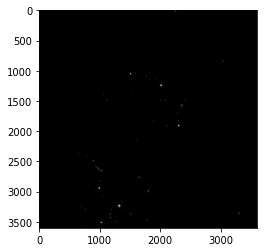

<AxesSubplot:>

In [60]:
show(ntl_out_image, cmap="gray")

In [353]:
dir(ntl_tif)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_block_shapes',
 '_closed',
 '_count',
 '_crs',
 '_crs_wkt',
 '_descriptions',
 '_dtypes',
 '_env',
 '_gcps',
 '_get_crs',
 '_get_rpcs',
 '_handle_crswkt',
 '_has_band',
 '_has_gcps_or_rpcs',
 '_mask_flags',
 '_nodatavals',
 '_offsets',
 '_read',
 '_rpcs',
 '_scales',
 '_set_all_descriptions',
 '_set_all_offsets',
 '_set_all_scales',
 '_set_all_units',
 '_set_attrs_from_dataset_handle',
 '_set_crs',
 '_set_gcps',
 '_set_nodatavals',
 '_set_rpcs',
 '_transform',
 '_units',
 'block_shapes',
 'block_size',
 'block_window',
 'block_windows',
 'bounds',
 'checksum

In [66]:
from rasterio.io import MemoryFile
out_meta = pop_tif.meta.copy()
out_meta.update(
    {
        "height": pop_mask_image_cropped.shape[0],
        "width": pop_mask_image_cropped.shape[1],
        "transform": pop_mask_image_cropped_transform
    }
)

tmp_data = np.expand_dims(pop_mask_image_cropped, axis=0)
tmp_data.shape

with MemoryFile() as memfile:
    with memfile.open(**out_meta) as dataset:
        dataset.write(tmp_data)
        
        height = tmp_data.shape[1]
        width = tmp_data.shape[2]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys= rasterio.transform.xy(dataset.transform, rows, cols)
        lons= np.array(xs)
        lats = np.array(ys)
        print('lons shape', lons.shape)
        print('lats shape', lats.shape)
        
#         tmp_polygon = Polygon(zip(np.reshape(lons, lons.shape[0]*lons.shape[1]), 
#                                  np.reshape(lats, lats.shape[0]*lats.shape[1])))
    
        
#     with memfile.open() as dataset:
#         new_tmp_data = dataset.read()

,minx,miny,maxx,maxy
0,19.992083,-20.900416,49.992083,9.099583


In [2]:
a = np.array([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12]])
b = np.array([[13,24,35,46], [55,64,73,82], [91, 100, 112, 124]])

c = np.stack([a,b], axis=0)

In [7]:
def test(val):
    return(val[0]+val[1])
    
d = np.apply_along_axis(test, 0, c)

In [8]:
d

array([[ 14,  26,  38,  50],
       [ 60,  70,  80,  90],
       [100, 110, 123, 136]])

In [12]:
with open('test.npy', 'wb') as f:
    np.save(f, d)

In [40]:
with open('../data/coords_to_country.npy', 'rb') as f:
    e = np.load(f, allow_pickle=True)

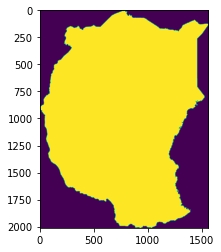

In [65]:
plt.imshow(np.where(e == None, 0, 255))

In [1]:
# from scipy.stats import qmc
# from poisson_disc_sampling import *

In [3]:
# def initialise_sites(min_radius, num_sites, points_to_ignore):
#     seed = 20
#     engine = qmc.PoissonDisk(d=2, radius=min_radius, seed=seed, ncandidates=100)
#     all_samples = []
#     while num_sites > 0:
#         sample = engine.integers(l_bounds=[0, 0], u_bounds=[2012,1563], n=1, endpoint=False)
#         print(type(sample))
#         if tuple(sample[0]) not in points_to_ignore:
#             all_samples.append(sample)
#             num_sites -= 1
#     return all_samples

In [5]:
# points_to_ignore

In [6]:
# u_bounds = [2012, 1563]
# radius = 50.0
# radius = radius/(np.sqrt(u_bounds[0]**2 + u_bounds[1]**2)/2.0)
# num_sites=30
# points_to_ignore = set(tuple(map(tuple, np.argwhere(e == None))))
# sites = initialise_sites(radius, num_sites, points_to_ignore)

In [218]:
from poisson_disc_sampling import *

ModuleNotFoundError: No module named 'poisson_disc_sampling'

In [29]:
with open('./data/coords_to_country.npy', 'rb') as f:
    e = np.load(f, allow_pickle=True)
        
u_bounds = [2012, 1563]
radius = 200.0
##ToDo convert radius in km to grid units.
# radius = radius/(np.sqrt(u_bounds[0]**2 + u_bounds[1]**2)/2.0)
num_sites=40
points_to_ignore = set(tuple(map(tuple, np.argwhere(e == None))))

In [31]:
pd = PoissonDisc(width=u_bounds[1], height=u_bounds[0], r=radius, k=10, n=num_sites, invalid_points=points_to_ignore)
sites = pd.sample()
sites = np.array(sites)
print(len(sites))

33


In [225]:
u_bounds = [2012, 1563]
radius = 200.0
with open("../data/population_based_sites.pkl", "rb") as f:
    sites = np.array(list(pickle.load(f)))

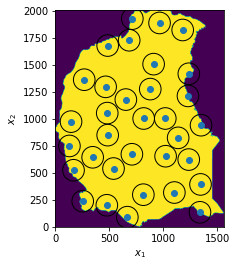

In [226]:
fig, ax = plt.subplots()

_ = ax.scatter(sites[:, 1], sites[:, 0])

circles = [plt.Circle((xi, yi), radius=radius/2, fill=False) for yi, xi in sites]

collection = PatchCollection(circles, match_original=True)

ax.add_collection(collection)

_ = ax.set(aspect='equal', xlabel=r'$x_1$', ylabel=r'$x_2$', xlim=[0, u_bounds[1]], ylim=[0, u_bounds[0]])

plt.imshow(np.where(e == None, 0, 255))

In [38]:
a = np.array([[1,2],[3,4], [5,6]])
b = np.copy(a[:, 0])
a[:, 0] = a[:, 1]
a[:, 1] = b
a

array([[2, 1],
       [4, 3],
       [6, 5]])

In [5]:
import pickle

In [12]:
def plot_voronoi_tessellation_multiple(base_file, iteration_counts, pop_data):
    for count in sorted(iteration_counts):
        plot_voronoi_tessellation(base_file, count, pop_data)
        plt.show()
        

def plot_voronoi_tessellation(base_file, iteration_count, pop_data):
    with open(base_file+str(iteration_count)+".pkl", "rb") as f:
        data = pickle.load(f)
        
        
    tess = data["site_to_point"]
    sites = data["sites_location"]
    
    u_bounds = [2012, 1563]
    
    fig, ax = plt.subplots(1, 2)
    
    ax[0].set_xlim(0, u_bounds[1])
    ax[0].set_ylim(0, u_bounds[0])

    for key, item in tess.items():
        item = np.array(list(item))
        ax[0].scatter(item[:, 1], item[:, 0])
        
#     com_sites = calculate_com_sites(tess, pop_data)

#     for id, site in sites.items():
#         ax[0].scatter(com_sites[id][1], com_sites[id][0], c="k")

    for id, site in sites.items():
        ax[0].scatter(sites[id][1], sites[id][0], c="k")
        
    capacity_sites = get_capacity_of_sites(tess, pop_data)
    variance = np.log(np.var(list(capacity_sites.values())))
    ax[1].bar(list(capacity_sites.keys()), list(capacity_sites.values()), label="Var: {}".format(variance))
    ax[1].legend()
    
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    
        
def calculate_com_sites(sites_to_point_dict, pop_data):
    com_sites = {}
    for key, item in sites_to_point_dict.items():
        numerator_x = 0.0
        numerator_y = 0.0
        total_mass = 0.0
        for point in item:
            mass = pop_data[point[0], point[1]]
            total_mass += mass
            
            numerator_x += (mass*point[1])
            numerator_y += (mass*point[0])
            
        com_x = np.floor(numerator_x/total_mass)
        com_y = np.floor(numerator_y/total_mass)
        
        com_sites[key] = [com_y, com_x]
        
    return com_sites

def get_capacity_of_sites(sites_to_point_dict, pop_data):
    capacity_sites = {}
    for id_, points in sites_to_point_dict.items():
        capacity = 0.0
        for point in points:
            capacity += pop_data[point[0], point[1]]
        capacity_sites[id_] = capacity
        
    return capacity_sites

In [13]:
# base_file = "../data/voronoi_tessellations/no-criterion_radius_200.0_sites_19_iteration-count_"

# sites = [[1506, 990], [1986, 1066], [1783, 826], [1629, 326]]
# with open("../data/voronoi_tessellations/no-criterion_radius_100.0_sites_15_site.pkl", "rb") as f:
#     tmp = pickle.load(f)
    
# sites = {}
# for i in range(len(tmp)):
#     sites[i] = list(tmp[i])
    
with open("../data/voronoi_tessellations/pop_data.npy", "rb") as f:
    pop_data = np.load(f)

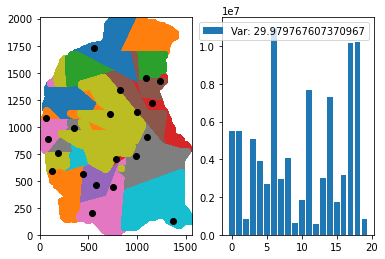

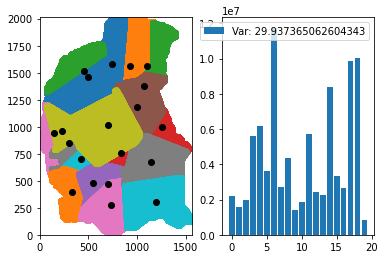

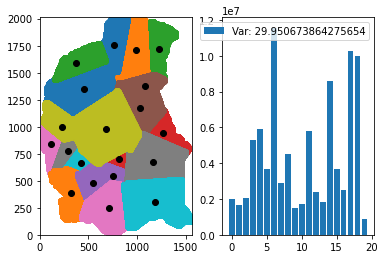

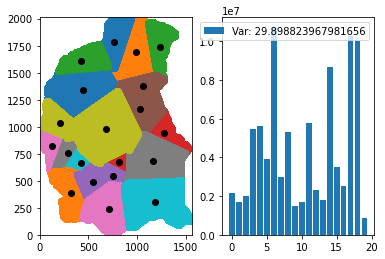

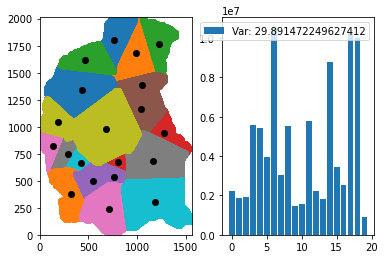

In [18]:
base_file = "../data/voronoi_tessellations/no-criterion_radius_100.0_sites_20_population_based_iteration-count_"
iteration_counts=np.arange(1, 6)
plot_voronoi_tessellation_multiple(base_file, iteration_counts, pop_data)

In [372]:
np.sqrt(2.6**29.6), np.sqrt(2.6**30.6)

(1385496.8730975206, 2234046.580074779)

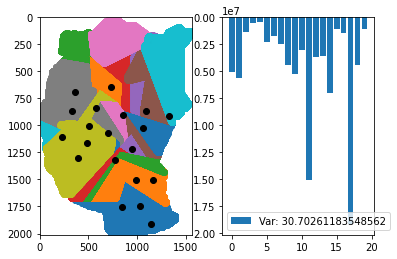

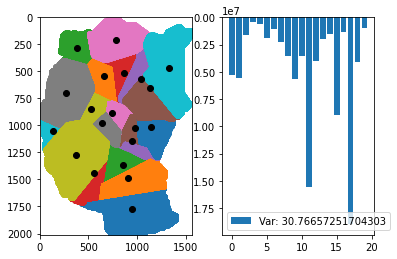

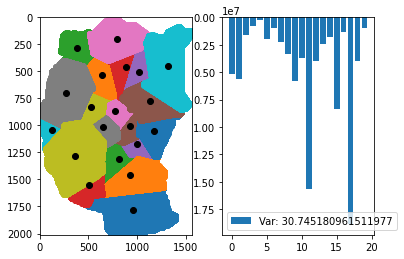

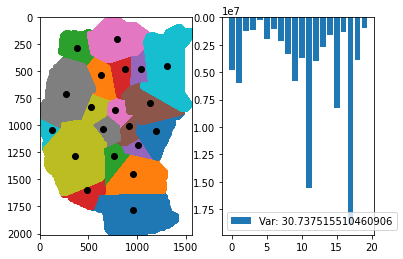

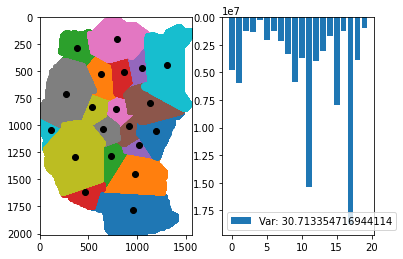

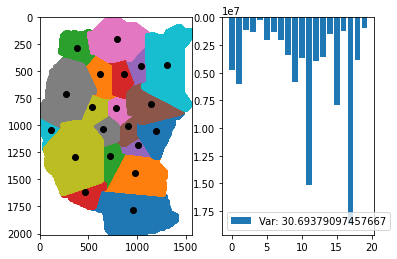

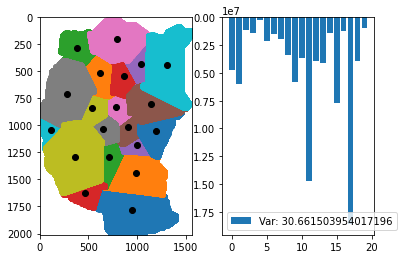

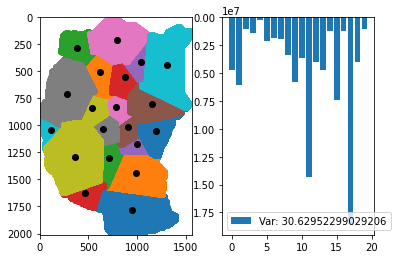

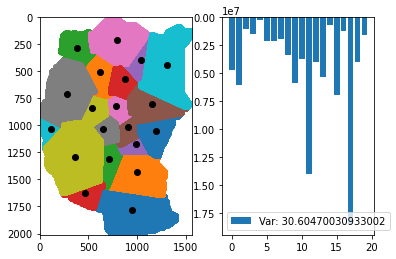

In [14]:
base_file = "../data/voronoi_tessellations/no-criterion_radius_100.0_sites_20_poisson_iteration-count_"
iteration_counts=np.arange(1, 10)
plot_voronoi_tessellation_multiple(base_file, iteration_counts, pop_data)

In [25]:
100.0*(1-1/2.6)

61.53846153846154

In [211]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon

In [325]:
with open("../data/sites_data.npy", "rb") as f:
    sites = np.load(f)

tmp = np.copy(sites[:, 0])
sites[:, 0] = sites[:, 1]
sites[:, 1] = tmp

In [263]:
def get_voronoi_regions(sites, x_bounds, y_bounds):
    vor = Voronoi(sites)
    
    filtered_regions = []
    
    for region in vor.regions:
        if region == []:
            continue
        flag = True
        
#         for index in region:
#             if index == -1:
#                 flag = False
#                 break
                
#             x, y = vor.vertices[index]
#             if x<x_bounds[0] or x>= x_bounds[1] or y<y_bounds[0] or y>=y_bounds[1]:
#                 flag = False
#                 break
                
        if flag:
            filtered_regions.append(region)
                
    vor.filtered_regions = filtered_regions
    return vor
        
    
def get_centroid_of_regions(vor):
    centroids = []
    for region in vor.filtered_regions:
        vertices = vor.vertices[region]
        centroid = Polygon(vertices).centroid
        x,y = np.floor(centroid.x), np.floor(centroid.y)
        centroids.append([x,y])
        
    vor.centroids = centroids
    
    return vor

def plot_vor_regions(vor):
    vor = get_centroid_of_regions(vor)
    centroids = np.array(vor.centroids)
    
    plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='o')
    
    for region in vor.filtered_regions:
        vertices = vor.vertices[region]
        
        xs, ys = zip(*vertices)
        xs, ys = list(xs), list(ys)
        xs.append(xs[0])
        ys.append(ys[0])
        
        plt.plot(xs, ys)

iteration: 1, num sites: 20


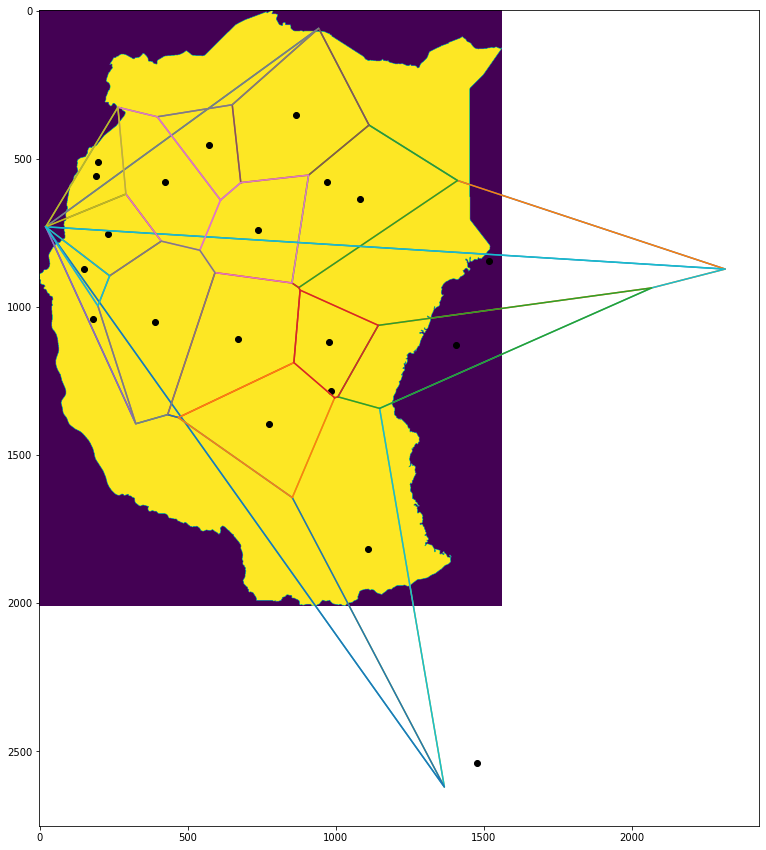

In [266]:
x_bounds = [0, 1563]
y_bounds = [0, 2012]


num_iters = 1


with open('../data/coords_to_country.npy', 'rb') as f:
    e = np.load(f, allow_pickle=True)


plt.figure(figsize=(15, 15))
plt.imshow(np.where(e == None, 0, 255))

# plt.xlim((0, 1563))
# plt.ylim((0, 2012))



centroids = np.copy(sites)

for _ in range(num_iters):
    print("iteration: {}, num sites: {}".format(_+1, len(centroids)))
    vor = get_voronoi_regions(centroids, x_bounds, y_bounds)
    vor = get_centroid_of_regions(vor)
    centroids = vor.centroids
    plot_vor_regions(vor)
    plt.show()
    


In [216]:
# vor.filtered_regions
# region = vor.vertices[vor.filtered_regions[0]]

20

In [250]:
new_pts = np.array([[0,0], [0, 2012], [1563, 2012], [1563,0]])
# new_pts = np.array([[999,999], [-999,999], [999,-999], [-999,-999]])
sites_cpy = np.copy(sites)
sites_cpy = np.append(sites_cpy, new_pts, axis=0)

In [251]:
vor = Voronoi(sites_cpy)

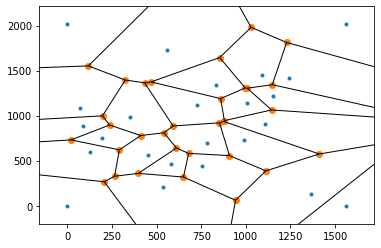

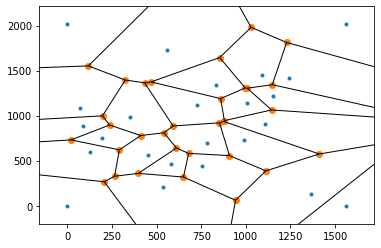

In [252]:
voronoi_plot_2d(vor)

In [267]:
from scipy.spatial import cKDTree

In [306]:
ys, xs = np.where(e != None)
pts = [[x,y] for x,y in zip(xs, ys)]

In [307]:
points = sites
voronoi_kdtree = cKDTree(points)
test_point_dist, test_point_regions = voronoi_kdtree.query(pts)
test_point_regions

array([ 6,  6,  6, ..., 17, 17, 17])

In [308]:
regions_to_pts = {}

for pt, region in zip(pts, test_point_regions):
    if region in regions_to_pts:
        regions_to_pts[region].append(pt)
    else:
        regions_to_pts[region] = [pt]

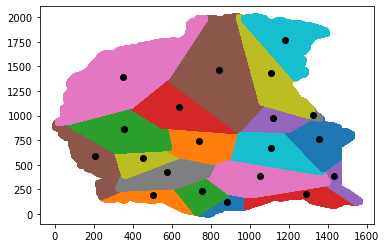

In [327]:
centroids = []
for region, region_pts in regions_to_pts.items():
    region_pts = np.array(region_pts)
    centroids.append(np.mean(region_pts, axis=0))
    plt.scatter(region_pts[:, 0], region_pts[:, 1])
    
centroids = np.array(centroids)
# plt.scatter(sites[:, 0], sites[:, 1], c='k', marker='o')
plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='o')

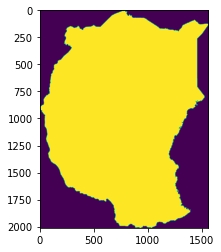

In [322]:
with open('../data/coords_to_country.npy', 'rb') as f:
    e = np.load(f, allow_pickle=True)

plt.imshow(np.where(e == None, 0, 255))


In [345]:
with open("../data/tmp.pkl", "rb") as f:
    data = pickle.load(f)
    
sites_data = np.array(list(data["sites_location"].values()))

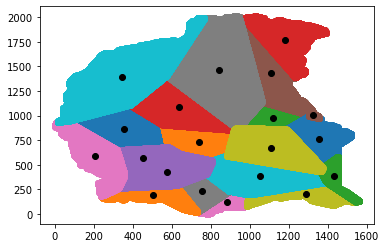

In [346]:
for site, site_pts in data["site_to_point"].items():
    site_pts = np.asarray(list(site_pts))
    plt.scatter(site_pts[:, 1], site_pts[:, 0])
    
plt.scatter(sites_data[:, 1], sites_data[:, 0], c='k', marker='o')

In [349]:
a = np.array([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12]])

In [356]:
sum(a[([0,1,2], [1,2,3])])

21

In [357]:
with open("../data/ntl_gdp_models.pkl", "rb") as f:
    ntl_gdp_models = pickle.load(f)

In [363]:
len(ntl_gdp_models["dmsp_ols_monthly"].coef_[0])

327

In [365]:
ntl_gdp_models

{'dmsp_ols_monthly': LinearRegression(fit_intercept=False),
 'dmsp_ols_annual': LinearRegression(fit_intercept=False),
 'viirs_monthly': LinearRegression(fit_intercept=False),
 'viirs_annual': LinearRegression(fit_intercept=False)}

In [368]:
list(np.unique(a))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [369]:
(1995-1993)*12 + (12-4+1)

33

In [373]:
fp = r'../data/earth_observation_group/new_data/F10_19921101_19921130.cloud2.light1.marginal0.line_screened.avg_vis.tif'
tmp_ntl = rasterio.open(fp)

In [378]:
dir(tmp_ntl)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_block_shapes',
 '_closed',
 '_count',
 '_crs',
 '_crs_wkt',
 '_descriptions',
 '_dtypes',
 '_env',
 '_gcps',
 '_get_crs',
 '_get_rpcs',
 '_handle_crswkt',
 '_has_band',
 '_has_gcps_or_rpcs',
 '_mask_flags',
 '_nodatavals',
 '_offsets',
 '_read',
 '_rpcs',
 '_scales',
 '_set_all_descriptions',
 '_set_all_offsets',
 '_set_all_scales',
 '_set_all_units',
 '_set_attrs_from_dataset_handle',
 '_set_crs',
 '_set_gcps',
 '_set_nodatavals',
 '_set_rpcs',
 '_transform',
 '_units',
 'block_shapes',
 'block_size',
 'block_window',
 'block_windows',
 'bounds',
 'checksum

In [124]:
from glob import glob
from scipy.interpolate import interp1d
from tqdm import tqdm

In [143]:
nrow, ncol = 1200, 2500
array_m = np.random.rand(nrow, ncol)
array_c = np.random.rand(nrow, ncol)
array_x = np.random.rand(nrow, ncol)

array_x*array_m + array_c

array([[0.23536788, 0.71506532, 0.61572216, ..., 0.63868043, 0.6454467 ,
        1.33514301],
       [0.95544552, 0.36025184, 1.19161999, ..., 0.37835929, 1.20279609,
        0.93925716],
       [0.59835248, 0.38128035, 1.17418931, ..., 1.17912937, 0.56059732,
        1.40004949],
       ...,
       [0.57434039, 0.85600231, 0.58958334, ..., 0.84895576, 0.92254431,
        1.24862966],
       [1.16790837, 1.56924116, 0.81678329, ..., 1.08986844, 0.88934869,
        0.62808053],
       [0.82959485, 1.21086951, 0.943038  , ..., 0.67468984, 0.41841771,
        0.52635883]])

In [204]:
# months_given = [0]
# months_to_find = []
# for i in range(1, (2020-1991+1)*12):
#     if i % 60 != 0:
#         months_to_find.append(i)
#     else:
#         months_given.append(i)
# months_given.append(360)

In [205]:
# with open('../data/coords_to_country.npy', 'rb') as f:
#     e = np.load(f, allow_pickle=True)

# # plt.imshow(np.where(e == None, 0, 255))

### Interpolation of Population count data

In [423]:
from rasterio import MemoryFile

In [442]:
def get_population_count_tif(year_to_find, month):
    years = np.arange(1990, 2021, 5)
    
    prev_avail_year, next_avail_year = None, None
    
    if year_to_find == 2021:
        prev_avail_year, next_avail_year = 2015, 2020
    elif year_to_find == 1990:
        prev_avail_year, next_avail_year = 1990, 1995
    else:
        for i in range(len(years)-1):            
            if years[i] <= year_to_find <= years[i+1]:
                prev_avail_year, next_avail_year = years[i], years[i+1]
                break
                
    month_idx = max(0, year_to_find-1-prev_avail_year)*12 + month
                
    first_pop_count_tif = rasterio.open("../data/population/count/{}/population_count.tif".format(prev_avail_year))
    meta_copy = first_pop_count_tif.meta.copy()
    first_pop_count_tif = first_pop_count_tif.read()
    second_pop_count_tif = rasterio.open("../data/population/count/{}/population_count.tif".format(next_avail_year)).read([1])

    first_pop_count_tif = np.squeeze(first_pop_count_tif)
    second_pop_count_tif = np.squeeze(second_pop_count_tif)

    array_m = (second_pop_count_tif - first_pop_count_tif)/60 #represents the slope for linear interpolation
    array_c = second_pop_count_tif - (array_m*60) #represents the intercept for linear interpolation           

    new_pop_count_tif = array_m*np.ones(array_m.shape)*month_idx + array_c
    new_pop_count_tif = np.expand_dims(new_pop_count_tif, axis=0)
    
    with MemoryFile() as memfile:
        with memfile.open(**meta_copy) as dataset:
            dataset.write(new_pop_count_tif)
            del new_pop_count_tif
            
        with memfile.open() as dataset:
            yield dataset

In [443]:
new_tif = get_population_count_tif(2000, 12)

In [444]:
tmp_tif = next(new_tif)

In [445]:
from copy import deepcopy

In [446]:
tmp_tif2 = deepcopy(tmp_tif)

TypeError: self._hds cannot be converted to a Python object for pickling

In [427]:
np.sum(tmp_tif.read())

243197411.84053507

In [295]:
tmp_tif = rasterio.open("../data/population/count/2000/population_count.tif").read()
np.sum(tmp_tif)

243197411.84053507

In [206]:
# pop_tif_data = None

# for month_folder in glob("../data/population/count/*"):
#     for pop_tif_file in glob(month_folder+"/*"):
#         if "tif" in pop_tif_file:
#             new_pop_tif_data = np.squeeze(rasterio.open(pop_tif_file).read([1]))
#             if pop_tif_data is None:
#                 pop_tif_data = new_pop_tif_data
#             else:                    
#                 print(pop_tif_data.shape, new_pop_tif_data.shape)
#                 pop_tif_data = np.dstack((pop_tif_data, new_pop_tif_data))

In [207]:
# def tmp_func(idx, months_given, pop_tif_data, interp_dict):
#     y = pop_tif_data[idx[0], idx[1],:]
#     f = interp1d(months_given, y)
#     interp_dict[(idx[0], idx[1])] = f

In [208]:
# tmp_array = []
# for i in tqdm(range(0, pop_tif_data.shape[0])):
#     tmp_row = []
#     for j in range(0, pop_tif_data.shape[1]):
#         tmp_row.append([i,j])
# #         tmp_array.append([i,j])

#     tmp_array.append(tmp_row)
# tmp_array = np.array(tmp_array)

In [209]:
# interp_dict = {}
# np.apply_along_axis(tmp_func, 2, tmp_array, months_given, pop_tif_data, interp_dict)

In [76]:
# interp_dict = {}

# for i in tqdm(range(0, pop_tif_data.shape[0])):
#     for j in range(0, pop_tif_data.shape[1]):
#         y = pop_tif_data[i,j,:]
#         f = interp1d(months_given, y)
#         interp_dict[(i,j)] = f
        
# #         predicted_y = f(months_to_find)
# #         y, predicted_y = list(y), list(predicted_y)
        
# #         complete_y = []
# #         for k in range(0, 361):
# #             if k % 60 == 0:
# #                 complete_y.append(y.pop(0))
# #             else:
# #                 complete_y.append(predicted_y.pop(0))
        
# #         tmp_dict[(i, j)] = complete_y
        

In [77]:
# with open("../data/population_interpolation_functions.pkl", "wb") as f:
#     pickle.dump(interp_dict, f)

In [210]:
# def func(val, interp_dict, start_idx):
#     return interp_dict[tuple(val)](start_idx)

In [211]:
# interp_dict[(0,0)](15)

In [212]:
# %time a = np.apply_along_axis(func, 2, tmp_array, interp_dict, 13)

In [213]:
# start_idx = 13
# start_year = 1992

# interp_pop_data = []

# for i in tqdm(range(0, pop_tif_data.shape[0])):
#     new_row = []
#     for j in range(0, pop_tif_data.shape[1]):
#         new_row.append(interp_dict[(i,j)](start_idx))
#     interp_pop_data.append(new_row)


In [214]:
# interp_pop_data[0]
# np.where(a != 0)

In [215]:
# x = [0, 4, 5]
# new_x = [1,2,3]
# y = [10, 20, 30]

# f = interp1d(x, y)

In [216]:
# f(new_x)

In [217]:
# f(3)

In [112]:
import pickle

In [113]:
with open("../data/monthly_ntl_filenames_viirs.pkl", "rb") as f:
    tmp_data = pickle.load(f)

In [116]:
tmp_data[2013]

['SVDNB_npp_20130101-20130131_global_vcmcfg_v10_c201605121529.avg_rade9h.tif',
 'SVDNB_npp_20130201-20130228_global_vcmcfg_v10_c201605131247.avg_rade9h.tif',
 'SVDNB_npp_20130301-20130331_global_vcmcfg_v10_c201605131250.avg_rade9h.tif',
 'SVDNB_npp_20130401-20130430_global_vcmcfg_v10_c201605131251.avg_rade9h.tif',
 'SVDNB_npp_20130501-20130531_global_vcmcfg_v10_c201605131256.avg_rade9h.tif',
 'SVDNB_npp_20130601-20130630_global_vcmcfg_v10_c201605131304.avg_rade9h.tif',
 'SVDNB_npp_20130701-20130731_global_vcmcfg_v10_c201605131305.avg_rade9h.tif',
 'SVDNB_npp_20130801-20130831_global_vcmcfg_v10_c201605131312.avg_rade9h.tif',
 'SVDNB_npp_20130901-20130930_global_vcmcfg_v10_c201605131325.avg_rade9h.tif',
 'SVDNB_npp_20131001-20131031_global_vcmcfg_v10_c201605131331.avg_rade9h.tif',
 'SVDNB_npp_20131101-20131130_global_vcmcfg_v10_c201605131332.avg_rade9h.tif',
 'SVDNB_npp_20131201-20131231_global_vcmcfg_v10_c201605131341.avg_rade9h.tif']

In [123]:
with open("../data/missing_filenames_viirs.pkl", "rb") as f:
    tmp_data2 = pickle.load(f)

In [124]:
tmp_data2[2013]

['SVDNB_npp_20130501-20130531_global_vcmcfg_v10_c201605131256.avg_rade9h.tif',
 'SVDNB_npp_20130601-20130630_global_vcmcfg_v10_c201605131304.avg_rade9h.tif',
 'SVDNB_npp_20130701-20130731_global_vcmcfg_v10_c201605131305.avg_rade9h.tif',
 'SVDNB_npp_20130801-20130831_global_vcmcfg_v10_c201605131312.avg_rade9h.tif',
 'SVDNB_npp_20130901-20130930_global_vcmcfg_v10_c201605131325.avg_rade9h.tif',
 'SVDNB_npp_20131001-20131031_global_vcmcfg_v10_c201605131331.avg_rade9h.tif',
 'SVDNB_npp_20131101-20131130_global_vcmcfg_v10_c201605131332.avg_rade9h.tif',
 'SVDNB_npp_20131201-20131231_global_vcmcfg_v10_c201605131341.avg_rade9h.tif']

In [122]:
with open("../data/missing_filenames_viirs.pkl", "wb") as f:
    pickle.dump(tmp_data2, f)

In [47]:
from glob import glob

In [48]:
all_files = {}
with open("../data/monthly_ntl_filenames_dmsp_ols.pkl", 'rb') as f:
    dmsp_files = pickle.load(f)
    all_files.update(dmsp_files)
    
with open("../data/monthly_ntl_filenames_viirs.pkl", "rb") as f:
    viirs_files = pickle.load(f)
    all_files.update(viirs_files)

In [49]:
downloaded_files = {}

for year_folder in glob("../data/earth_observation_group/monthly/*"):
    year = int(year_folder.split("/")[-1])
    year_files = []
    for month_folder in glob(year_folder+"/*"):
        for file in glob(month_folder+"/*"):
            if ".tif" in file:
                year_files.append(file.split("/")[-1])
    downloaded_files.update({year: year_files})

In [50]:
missing_files = {}

count1, count2 = 0,0
for year in downloaded_files.keys():
    missing_files[year] = list(set(all_files[year]) - set(downloaded_files[year]))
    count1 += len(all_files[year])
    count2 += len(downloaded_files[year])

In [51]:
missing_files_viirs = {year: missing_files[year] for year in viirs_files.keys()}

In [52]:
# with open("../data/missing_filenames_viirs.pkl", "wb") as f:
#     pickle.dump(missing_files_viirs, f)

In [92]:
import os

In [121]:
def combine_ntl_data_in_tif(years=None):
    if years is None:
        years = np.arange(1992, 2013, 1)
        
        for year in years:
            for month_folder in glob("../data/earth_observation_group/monthly/{}/*".format(year)):
                tif_files = [file for file in glob(month_folder+"/*") if ".tif" and "cloud" in file]
                
                if len(tif_files) == 2:
                    print("Combining for year: ", year)
                    first_tif = rasterio.open(tif_files[0])
                    tif_meta = first_tif.meta.copy()
                    
                    first_tif = first_tif.read([1])
                    second_tif = rasterio.open(tif_files[1]).read([1])
                    
                    avg_tif = (first_tif + second_tif)/2.0
                    
                    
                    just_tif_name = "combined.global.avg_vis.tif"
                    new_tif_name = "/".join(tif_files[0].split("/")[:-1])+"/"+just_tif_name

                    with rasterio.open(new_tif_name, "w", **tif_meta) as dst:
                        dst.write(avg_tif)
                        
                    ## Relocate different satellite files to a new folder
                    combine_folder_path = month_folder+"/various_satellite_data"
                    if not os.path.isdir(combine_folder_path):
                        os.mkdir(combine_folder_path)
                        
                    for file in tif_files:
                        dst = combine_folder_path + "/" + file.split("/")[-1]
                        os.rename(file, dst)
                    
                    
                    
                


In [122]:
combine_ntl_data_in_tif()

Combining for year:  1994
Combining for year:  1994
Combining for year:  1994
Combining for year:  1994
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1997
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1998
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  1999
Combining for year:  2000
Combining fo

In [358]:
for year_folder in glob("../data/earth_observation_group/monthly/*"):
    for month_folder in glob(year_folder+"/*"):
        flag = False
        for file in glob(month_folder+"/*"):
            if ".tif" in file:
                flag = True
                break
        if not flag:
            print(year_folder.split("/")[-1], month_folder.split("/")[-1])
        
        

In [357]:
def interpolate_ntl_tif(year_to_find, month, prev_avail_year, prev_avail_month, next_avail_year, next_avail_month, diff, month_idx, new_ntl_file):
    for file in glob("../data/earth_observation_group/monthly/{}/{}/*".format(prev_avail_year, prev_avail_month)):
        if ".tif" in file:
            first_filename = file
            
    for file in glob("../data/earth_observation_group/monthly/{}/{}/*".format(next_avail_year, next_avail_month)):
        if ".tif" in file:
            second_filename = file
    
    first_pop_count_tif = rasterio.open(first_filename)
    meta_copy = first_pop_count_tif.meta.copy()
    first_pop_count_tif = first_pop_count_tif.read()
    second_pop_count_tif = rasterio.open(second_filename).read([1])

    first_pop_count_tif = np.squeeze(first_pop_count_tif)
    second_pop_count_tif = np.squeeze(second_pop_count_tif)

    array_m = (second_pop_count_tif - first_pop_count_tif)/diff #represents the slope for linear interpolation
    array_c = second_pop_count_tif - (array_m*diff) #represents the intercept for linear interpolation           

    new_pop_count_tif = array_m*np.ones(array_m.shape)*month_idx + array_c
    new_pop_count_tif = np.expand_dims(new_pop_count_tif, axis=0)
    
    with rasterio.open(new_ntl_file, "w", **meta_copy) as dst:
        dst.write(new_pop_count_tif)

In [353]:
year_to_find = 2009
month = "01"
prev_avail_year = 2008
prev_avail_month = "12"
next_avail_year = 2009
next_avail_month = "02"
diff = 2
month_idx = 1
new_ntl_file = "../data/earth_observation_group/monthly/{}/{}/interpolated_ntl.global.avg_vis.tif".format(year_to_find, month)
new_ntl_file

'../data/earth_observation_group/monthly/2009/01/interpolated_ntl.global.avg_vis.tif'

In [354]:
interpolate_ntl_tif(year_to_find, month, prev_avail_year, prev_avail_month, next_avail_year, next_avail_month, diff, month_idx, new_ntl_file)

In [355]:
tmp_tif = rasterio.open(new_ntl_file).read()

In [356]:
np.sum(tmp_tif)

5782416.0

In [380]:
a = np.random.rand(10,2)

In [381]:
pts = ((0,5), (0,1))
b = a[pts]
b

array([0.39878474, 0.73383575])

In [383]:
year = 1992
month = 5

In [389]:
b = b.astype(str)

In [392]:
np.char.add(b, "dff")

array(['0.39878473664312974dff', '0.7338357476501608dff'], dtype='<U35')

In [393]:
a = np.array([['a', 'b'], ['c', 'd']])

In [396]:
np.char.add(a,a)

array([['aa', 'bb'],
       ['cc', 'dd']], dtype='<U2')

In [397]:
import pandas as pd
lambda_data = pd.read_csv("../data/revised_gdp_dmsp_ols_monthly.csv")

In [402]:
lambda_data[lambda_data["Region_temporal"].isin(["BDI_1992_6", "BDI_1992_4"])]

,Region_temporal,log_gdp,log_ntl,dummy_vars_sum,log_gdp_hat,spi_error_std,cent_error_std,lambda,log_gdp_revised
0,BDI_1992_4,5.308094,-0.448935,4.704774,4.703889,1.534008,1.977306,0.466,5.026534
2,BDI_1992_6,5.291388,-0.278076,4.704897,4.704348,1.534008,1.977306,0.466,5.017828


In [403]:
c = [1,2,3]*2

In [404]:
c

[1, 2, 3, 1, 2, 3]

In [407]:
np.exp(np.log(4))

4.0

In [409]:
(np.random.rand(10,2)*np.random.rand(10,2)).shape

(10, 2)

In [415]:
month = "12"

In [416]:
int(month[1:]) if month[0]== 0 else int(month)

12

In [421]:
tmp_ntl = rasterio.open("../data/population/count/1995/population_count.tif")

In [422]:
tmp_ntl.read().shape

(1, 3600, 3600)

In [467]:
def tmp_func():
    return pd.read_csv("../data/country_codes.csv").sort_values(by=["Alpha2_code"])

In [468]:
tmp = tmp_func()

In [469]:
tmp

,country,Alpha2_code,Alpha3_code,numeric
4,Andorra,AD,AND,20
232,United Arab Emirates (the),AE,ARE,784
0,Afghanistan,AF,AFG,4
8,Antigua and Barbuda,AG,ATG,28
6,Anguilla,AI,AIA,660
...,...,...,...,...
245,Yemen,YE,YEM,887
141,Mayotte,YT,MYT,175
205,South Africa,ZA,ZAF,710
246,Zambia,ZM,ZMB,894


In [496]:
with open("../data/coords_to_country.npy", "rb") as f:
    country_codes = np.load(f, allow_pickle=True)

In [492]:
pts = ((0,0,0,0,), (1,2,3,4))
pts = np.where(country_codes != None)
a = country_codes[pts]

In [495]:
np.char.add(a.astype(str), "dfdfdf")

array(['KENdfdfdf', 'KENdfdfdf', 'KENdfdfdf', ..., 'TZAdfdfdf',
       'TZAdfdfdf', 'TZAdfdfdf'], dtype='<U9')

In [493]:
a

array(['KEN', 'KEN', 'KEN', ..., 'TZA', 'TZA', 'TZA'], dtype=object)

In [529]:
pts = np.where(country_codes != None)

In [530]:
# country_codes[pts]*2.0/(country_codes[pts]+3.0)

In [531]:
# country_codes[pts] + 2

In [532]:
b = country_codes[pts]
b[np.where(b <= 0)] = 2

In [533]:
np.where(b == 0.0)

(array([], dtype=int64),)

In [524]:
c.shape
np.squeeze(c).shape

(10,)

In [525]:
np.where(c == 1000)

(array([], dtype=int64), array([], dtype=int64))

In [534]:
a = []
a.extend([1,2,3])
a.extend([4,5,6])

In [535]:
a

[1, 2, 3, 4, 5, 6]

In [536]:
lambda_df = pd.read_csv("../data/revised_gdp_dmsp_ols_monthly.csv")

In [549]:
tmp_dict = {val[0]: val[1] for _, val in lambda_df[["Region_temporal", "lambda"]].iterrows()}

In [570]:
keys = list(np.random.choice(list(tmp_dict.keys()), size=20))*int((2135442/10))

In [571]:
len(keys)

4270880

In [572]:
%timeit -n 1 -r 1 [tmp_dict.get(key) for key in keys]

2.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [573]:
%timeit -n 1 -r 1 a = list(map(tmp_dict.get, keys))

198 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [578]:
gdp_df = pd.read_csv("../data/gdp/monthly_gdp_per_capita.csv")
gdp_df.head(1)

,Country Name,Country Code,1992_1,1992_2,1992_3,1992_4,1992_5,1992_6,1992_7,1992_8,...,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,2021_10,2021_11,2021_12
0,Afghanistan,AFG,265.948241,264.26734,262.586439,260.905538,259.224637,257.543736,255.862835,254.181934,...,479.838568,467.495906,455.153245,442.810583,430.467922,418.12526,405.782599,393.439937,381.097276,368.754614


In [579]:
tmp_dict = {val[0]: val[1] for _, val in gdp_df[["Country Code", "1992_1"]].iterrows()}

In [581]:
keys = list(np.random.choice(list(tmp_dict.keys()), size=20))*int((2135442/10))

In [585]:
a = list(map(tmp_dict.get, keys))

In [590]:
a = np.ones((10,1))
a = np.squeeze(a)

In [596]:
a = {1: [1,2,3], 2:[]}
for key, val in a.items():
    if len(val) == 0:
        del a[key]

RuntimeError: dictionary changed size during iteration

In [621]:
np.random.seed(10)
a = np.random.choice(np.arange(1, 101, 1), p=weights, size=10, replace=False)
a

array([73,  2, 54, 67, 41, 17, 14, 13,  9, 62])

In [625]:
a = np.arange(1992, 2022, 1)
b = np.ceil(len(a)/8)
counter = 0
n_procs = 8
for i in range(n_procs):
    print(a[counter: counter+int(b)])
    counter += int(b)

[1992 1993 1994 1995]
[1996 1997 1998 1999]
[2000 2001 2002 2003]
[2004 2005 2006 2007]
[2008 2009 2010 2011]
[2012 2013 2014 2015]
[2016 2017 2018 2019]
[2020 2021]


In [614]:
a

9

In [830]:
def get_missing_sim_files(all_sim_files):
    collected_data  = {}
    for file_ in glob("../data/sims/*"):
        if ".pkl" not in file_:
            continue
            
        file_ = file_.split("/")[-1]
        year, month, radius, seed = file_.split("_")
        year, month = int(year), int(month)
        radius = float(radius.split("-")[-1])
        seed = int(seed[5:6])
        
        if year not in collected_data:
            collected_data[year] = {month: [str(radius)+"_"+str(seed)]}
        else:
            if month not in collected_data[year]:
                collected_data[year].update({month: [str(radius)+"_"+str(seed)]})
            else:
                collected_data[year][month].append(str(radius)+"_"+str(seed))
                
    missing_data = {}
    for year, data in all_sim_files.items():
        if year not in collected_data:
            missing_data[year] = all_sim_files[year]
            continue
            
        missing_data[year] = {}
        for month, month_data in data.items():
            if month not in collected_data[year]:
                missing_data[year][month] = all_sim_files[year][month]
            else:
                missing_data[year][month] = list(set(all_sim_files[year][month]) - set(collected_data[year][month]))
                
    return missing_data
        

def get_required_sim_files(all_min_radius, all_seeds):
    all_files = {}
    years = np.arange(1992, 2022, 1)
    
    for year in years:
        month_range = np.arange(4, 13, 1) if year == 1992 else np.arange(1, 13, 1)
        year_data = {}
        for month in month_range:
            month_data = []
            for radius in all_min_radius:
                for seed in all_seeds:
                    month_data.append(str(radius)+"_"+str(seed))
            year_data[month] = month_data
        all_files[year] = year_data
    return all_files
        

In [850]:
all_min_radius = [10.0, 25.0]
all_min_radius.extend(np.arange(50.0, 350.0, 50.0))
all_seeds = [1]
all_sim_files = get_required_sim_files(all_min_radius, all_seeds)
missing_data = get_missing_sim_files(all_sim_files)

In [851]:
total = 0
for key, data in missing_data.items():
    count = sum([len(month_data) for month_data in data.values()])
    total += count
    print(key, count)
    
print(total)

1992 57
1993 95
1994 95
1995 85
1996 0
1997 0
1998 0
1999 40
2000 0
2001 0
2002 0
2003 32
2004 88
2005 96
2006 96
2007 88
2008 0
2009 0
2010 0
2011 40
2012 0
2013 0
2014 0
2015 26
2016 0
2017 81
2018 0
2019 84
2020 0
2021 89
1092


In [743]:
for key, data in missing_data.items():
    count = sum([len(month_data) for month_data in data.values()])
    print(key, count)

1992 0
1993 21
1994 82
1995 20
1996 0
1997 18
1998 77
1999 21
2000 0
2001 0
2002 0
2003 0
2004 0
2005 0
2006 8
2007 21
2008 0
2009 0
2010 0
2011 0
2012 0
2013 4
2014 0
2015 0
2016 0
2017 0
2018 0
2019 0
2020 0
2021 0


In [715]:
missing_data[1992]
# 1992_4: [100.0_1]

{4: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 5: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 6: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 7: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 8: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 9: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 10: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 11: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2'],
 12: ['50.0_2',
  '150.0_2',
  '350.0_2',
  '100.0_2',
  '300.0_2',
  '250.0_2',
  '200.0_2']}

In [723]:
with open("../data/sims/1992_10_radius-100.0_seed-1.pkl", "rb") as f:
    sim_data = pickle.load(f)

In [737]:
gdp_sum = sim_data["gdp_sum"]
pop_sum = sim_data["site_pop_sum"]

gdp_per_capita_sum = []
for key in gdp_sum.keys():
    gdp_per_capita_sum.append(round(gdp_sum[key]/pop_sum[key], 2))

<BarContainer object of 28 artists>

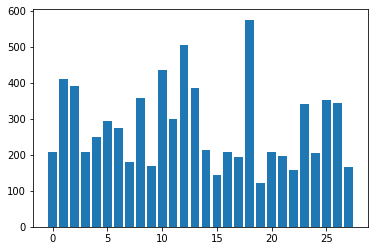

In [740]:
plt.bar(np.arange(0, len(gdp_sum.keys())), gdp_per_capita_sum)

In [748]:
pop_tif = rasterio.open("../data/population/count/2005/population_count.tif")

In [776]:
pop_data = pop_tif.read(1)

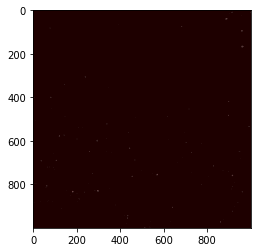

In [752]:
# plt.imshow(pop_data[0:1000, 0:1000], cmap="pink")

In [773]:
# pop_data = 255*(pop_data - np.min(pop_data))/(np.max(pop_data) - np.min(pop_data))
# pop_data[np.where(pop_data > 0.0)] = 255

In [800]:
# plt.hist(pop_data, bins=10)
tmp = 255*(pop_data - np.min(pop_data))/(np.max(pop_data) - np.min(pop_data))
tmp[np.where(tmp == 0)] = 1.0
tmp = np.exp(tmp)

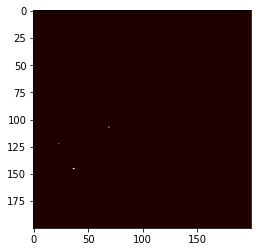

In [804]:
plt.imshow(tmp[2000:2200, 1000:1200], cmap='pink')

In [798]:
# _, bins = pd.cut(pop_data.flatten(), 10, retbins=True)

In [802]:
# bins

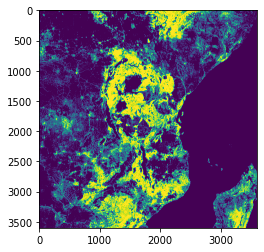

In [774]:
plt.imshow(pop_data)

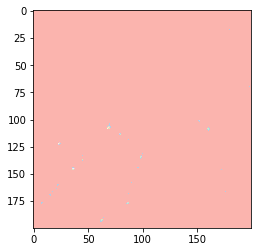

In [785]:
plt.imshow(pop_data[2000:2200, 1000:1200], cmap="Pastel1")

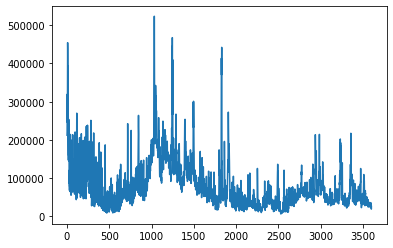

In [765]:
plt.plot(np.arange(1, 3600+1, 1), np.sum(pop_data, axis=1))

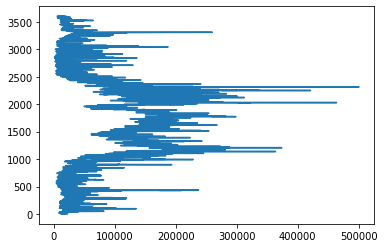

In [766]:
plt.plot(np.sum(pop_data, axis=0), np.arange(1, 3600+1, 1))

In [821]:
for year in np.arange(1992, 1993, 1):
    for month in np.arange(4, 13, 1):
        all_radius = [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0]
        for radius in all_radius:
            with open("../data/sims/{}_{}_radius-{}_seed-1.pkl".format(year, month, radius), "rb") as f:
                data = pickle.load(f)
                print("year: {}, month: {}, radius: {}, num sites: {}".format(year, month, radius, len(data["gdp_sum"])))
            
        print("_"*20)

year: 1992, month: 4, radius: 50.0, num sites: 38
year: 1992, month: 4, radius: 100.0, num sites: 29
year: 1992, month: 4, radius: 150.0, num sites: 20
year: 1992, month: 4, radius: 200.0, num sites: 14
year: 1992, month: 4, radius: 250.0, num sites: 11
year: 1992, month: 4, radius: 300.0, num sites: 7
year: 1992, month: 4, radius: 350.0, num sites: 5
____________________
year: 1992, month: 5, radius: 50.0, num sites: 38
year: 1992, month: 5, radius: 100.0, num sites: 26
year: 1992, month: 5, radius: 150.0, num sites: 21
year: 1992, month: 5, radius: 200.0, num sites: 14
year: 1992, month: 5, radius: 250.0, num sites: 10
year: 1992, month: 5, radius: 300.0, num sites: 6
year: 1992, month: 5, radius: 350.0, num sites: 5
____________________
year: 1992, month: 6, radius: 50.0, num sites: 38
year: 1992, month: 6, radius: 100.0, num sites: 27
year: 1992, month: 6, radius: 150.0, num sites: 21
year: 1992, month: 6, radius: 200.0, num sites: 15
year: 1992, month: 6, radius: 250.0, num sites:

1. Add 10.0, 25.0 to radius
2. Move out site initialisation and voronoi tessellation from the min_radius loop


In [ ]:
temporal scale = [month, quarter, year, 5 years]

In [816]:
gdp distribution, gdp growth distribution

SyntaxError: invalid syntax (3567752374.py, line 1)

In [ ]:
((50.0, month)*5)  ((100.0, month)*5) 

In [ ]:
## look for observables for correlation matrix. Look for network analysis like nodes and centrailty

In [817]:
# At larger scale it is possible to get more noise and we lose the underlying network topology

SyntaxError: invalid syntax (3537487650.py, line 1)

In [818]:
"_".join([1992, 1])

TypeError: sequence item 0: expected str instance, int found

In [826]:
a = [0,12] 
a.extend(np.arange(50.0, 350.0, 50.0))

In [827]:
a

[0, 12, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0]